# Testing the model on the LFW (Labeled Faces in the Wild) database

*Creators: Lajos Bodo, Szilard Kosa*

Description: We use this notebook to test our trained models.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tables

In [3]:
# This library let's us work with hdf5 format files.
import tables
# Fundamental package for scientific computing with Python.
import numpy as np
# Used for printing the current progress only
from IPython.display import clear_output
# We use matplotlib to display the images
import matplotlib.pyplot as plt
%matplotlib inline

# Imports necessary for the model
import keras
from keras.layers import Activation, Conv2D, MaxPooling2D, Input, Dense, Flatten, Lambda, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.models import Model
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


## Loading the dataset

In this cell we load the dataset_lfw.hdf5 and set_index.txt files.
Then we process the dataset into two lists, one containing the matched sets, the other the mismatched sets.

In [4]:
# Load the lfw dataset
hdf5_path_lfw = "drive/My Drive/DeepLearning/test/dataset_lfw.hdf5"
hdf5_file_lfw = tables.open_file(hdf5_path_lfw, mode='r')
print("Opening %s ."%(hdf5_path_lfw))

# Lists for storing the data from the dataset.
matched = []
mismatched = []
matched_set = []
mismatched_set = []

# Load the set_indexes
set_index_file = open('drive/My Drive/DeepLearning/test/set_index.txt', 'r')
set_indexes = []
for line in set_index_file:
	set_indexes.append((int(line.split()[0])))

# Defining variables needed for the algorithm.
data_num_lfw = hdf5_file_lfw.root.images.shape[0]
number_of_sets = 10
current_set = 0
is_same = True
# Reads the defined amount of pictures for each person.
for i in range(0, data_num_lfw, 2):
    #print("Loading: %.3f %%"%(float(i)/float(data_num_lfw-1)*100))
    if i/2 in set_indexes:
      is_same = not is_same
    # Create a list with matched pairs from one set.
    if is_same:
        same_pair = [hdf5_file_lfw.root.images[i],hdf5_file_lfw.root.images[i+1]]
        matched_set.append(same_pair)
    # Create a list with mismatched pairs from one set.
    else:
        different_pair = [hdf5_file_lfw.root.images[i],hdf5_file_lfw.root.images[i+1]]
        mismatched_set.append(different_pair)
    # Append the lists containing the current set's pairs to the final lists.
    if (i+2)/2 in set_indexes and not is_same:
      print (i)
      matched.append(matched_set)
      mismatched.append(mismatched_set)
      matched_set = []
      mismatched_set = []

# Closing the file.
hdf5_file_lfw.close()
print()
print("HDF5 file closed.")

Opening drive/My Drive/DeepLearning/test/dataset_lfw.hdf5 .
1018
2018
3038
4048
5042
6034
7070
8074
9078
10020

HDF5 file closed.


## Loading the model

First we define the triplet loss function which is necessary for the model
Then we load our model.

In [0]:
# The tripet loss function, which is needed for the model
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """

    anchor = y_pred[:,:128]
    positive = y_pred[:,128:256]
    negative = y_pred[:,256:]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [0]:
from keras.models import load_model
# Loading the model
model = load_model('drive/My Drive/DeepLearning/test/weights_final.hdf5', custom_objects={'triplet_loss': triplet_loss, 'tf': tf})

## Making the predictions

In the following cells the model calculates the distance between the images of each pair

In [0]:
# This function makes a prediction with the model on the test datasets
# network: the model which makes the predictions
# test: the matched and mismatched arrays to make the predictions
def predictions(network, test):
  distances = []
  # Iterate through the 10 sets
  for i in range(10):
    distances_set = []
    # Iterate through the pairs in the set
    for j in range(len(test[i])):
      # Increase img dimensions
      img1 = np.expand_dims(test[i][j][0], axis=0)
      img1 = np.expand_dims(img1, axis=3)
      img2 = np.expand_dims(test[i][j][1], axis=0)
      img2 = np.expand_dims(img2, axis=3)
      # Calculate the network's prediction on img1 and img2
      preds = network.predict([img1,img2,img1])[0]
      pred1 = preds[:128]
      pred2 = preds[128:256]
      # Calculate the distance between the two images
      dist = np.sum(np.square(pred1-pred2))
      # Store the distance between the images
      distances_set.append(dist)
    # Store th set's distances between the two image of each pair.
    distances.append(distances_set)
  # Return the predicted distances
  return distances

In [0]:
# Calculate prediction (distance) values for the matched sets and the mismatched sets
matched_preds = predictions(model, matched)
mismatched_preds = predictions(model, mismatched)

# Testing

This function calculates how many pair is considered matched from the matched
set and how many pair is considered mismatched from the mismatched set at a given
threshold

test_set: the chosen set for testing

threshold: the chosen threshold value for this test.


In [0]:

def lfw_test(test_set, threshold):
  same_pair = 0
  different_pair = 0
  for k in range(len(matched_preds[test_set])):
    if(matched_preds[test_set][k] < threshold):
      same_pair += 1
  for k in range(len(mismatched_preds[test_set])):
    if(mismatched_preds[test_set][k] >= threshold):
      different_pair += 1
  return same_pair, different_pair

## Determine the testing threshold for each set

During the testing process, we calculate each sets best threshold value.
The set's test threshold is calculated from the nine other set's best threshold.



In [11]:
# create lists to store the true positive and other values  for th ROC curve
TP_history = []
TN_history = []
FN_history = []
FP_history = []
# Variables for the iteration
best_thresholds = []
test_thresholds = []
total_threshold = 0
max_threshold = 4
step = 200
# Iterates through the sets
for i in range(10):
    best_result =  0
    TP_set_history = []
    TN_set_history = []
    FN_set_history = []
    FP_set_history = []
    # Goes through the specified threshold interval to find the best threshold fot the current set
    for threshold in np.linspace(0, max_threshold, step):
        same_pair, different_pair = lfw_test(i, threshold)
        result = same_pair + different_pair
        if result > best_result:
            best_result = result
            best_set_threshold = threshold
        TP_set_history.append(same_pair)
        FN_set_history.append(len(matched_preds[i])-same_pair)
        TN_set_history.append(different_pair) 
        FP_set_history.append(len(mismatched_preds[i])-different_pair)
    best_thresholds.append(best_set_threshold)
    total_threshold += best_set_threshold
    TP_history.append(TP_set_history)
    TN_history.append(TN_set_history)
    FN_history.append(FN_set_history)
    FP_history.append(FP_set_history)
    
# Assign a threshold to each set. The assigned threshold is the average of the other nine set's best threshold
for i in range(10):
    test_thresholds.append((total_threshold-best_thresholds[i])/9.0)

print(best_thresholds) 
print(test_thresholds)

[0.7638190954773869, 0.8241206030150754, 0.7638190954773869, 0.7437185929648241, 0.8241206030150754, 0.9246231155778895, 0.864321608040201, 0.8241206030150754, 0.8241206030150754, 0.7839195979899498]
[0.8196538246789502, 0.8129536571747626, 0.8196538246789502, 0.8218872138470128, 0.8129536571747626, 0.80178671133445, 0.8084868788386376, 0.8129536571747626, 0.8129536571747626, 0.8174204355108876]


## Results
Calculate the true positives, the true negatives, the false negatives and the false positives
Then calculate the precision, the recall and the accuracy

In [12]:
average_precision = 0
average_recall = 0
average_accuracy = 0
for tset in range (10):
  TP, TN = lfw_test(tset, best_thresholds[tset])
  TP = TP
  TN = TN
  FN = (len(matched_preds[tset])-TP)
  FP = (len(mismatched_preds[tset])-TN)
  
  average_precision += TP/(TP+FP)/10
  average_recall += TP/(TP+FN)/10
  average_accuracy += (TP+TN)/(TP+TN+FP+FN)/10

  # Printing the results for each set
  print("{}. test_set:".format(tset+1))
#   print("TP: {}".format(TP))
#   print("TN: {}".format(TN))
#   print("FN: {}".format(FN))
#   print("FP: {}".format(FP))

  print("Precision: {:1.4f}, Recall: {:1.4f}, Accuracy: {:1.4f}".format(TP/(TP+FP), TP/(TP+FN), (TP+TN)/(TP+TN+FP+FN)))
#   print("Recall: {}".format(TP/(TP+FN)))
#   print("Accuracy: {}".format((TP+TN)/(TP+TN+FP+FN)))
  print("="*40)

1. test_set:
Precision: 0.8750, Recall: 0.7656, Accuracy: 0.8275
2. test_set:
Precision: 0.8485, Recall: 0.7809, Accuracy: 0.8200
3. test_set:
Precision: 0.8803, Recall: 0.7687, Accuracy: 0.8235
4. test_set:
Precision: 0.8860, Recall: 0.7125, Accuracy: 0.8198
5. test_set:
Precision: 0.8355, Recall: 0.7846, Accuracy: 0.8169
6. test_set:
Precision: 0.7929, Recall: 0.8845, Accuracy: 0.8246
7. test_set:
Precision: 0.8718, Recall: 0.8981, Accuracy: 0.8803
8. test_set:
Precision: 0.8952, Recall: 0.8135, Accuracy: 0.8586
9. test_set:
Precision: 0.8439, Recall: 0.7874, Accuracy: 0.8187
10. test_set:
Precision: 0.8905, Recall: 0.7759, Accuracy: 0.8365


Printing the average precision, recall and accuracy

In [13]:
print("Average precision: {:1.4f}".format(average_precision))
print("Average recall: {:1.4f}".format(average_recall))
print("Average accuracy: {:1.4f}".format(average_accuracy))

Average precision: 0.8620
Average recall: 0.7972
Average accuracy: 0.8326


Generating ROC curves for each set, then calculate the average ROC curve

In [0]:
# Generating ROC curves for each set
TPR = []
FPR = []
TPR_average = []
FPR_average = []

for k in range(10):
  TPRk = []
  FPRk = []
  for i in range(len(TP_history[k])):
    TPRk.append(TP_history[k][i]/(TP_history[k][i]+FN_history[k][i]))
    FPRk.append(1-TN_history[k][i]/(TN_history[k][i]+FP_history[k][i]))
  TPR.append(TPRk)
  FPR.append(FPRk)
  
# Averaging the generated ROC curves
for i in range(200):
  TPR_element_average = 0
  FPR_element_average = 0
  for k in range(10):
    TPR_element_average += TPR[k][i]/10
    FPR_element_average += FPR[k][i]/10
  TPR_average.append(TPR_element_average)
  FPR_average.append(FPR_element_average)
  

Display the average ROC curve and the average AUC

Average AUC: 0.9085


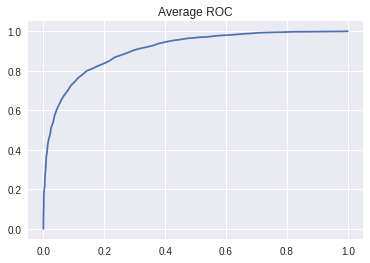

In [15]:
plt.figure()

plt.plot(FPR_average, TPR_average)
plt.title("Average ROC")

# Calculating AUC
from sklearn.metrics import auc
print("Average AUC: {:1.4f}".format(auc(FPR_average, TPR_average)))

Display each set's ROC curve and AUC

AUC0: 0.9065960260826772
AUC1: 0.8776620425926814
AUC2: 0.9038408165782656
AUC3: 0.9079166666666667
AUC4: 0.8964629287727139
AUC5: 0.909626798926742
AUC6: 0.9412185845327765
AUC7: 0.924984126984127
AUC8: 0.897256794513589
AUC9: 0.9178964459678873


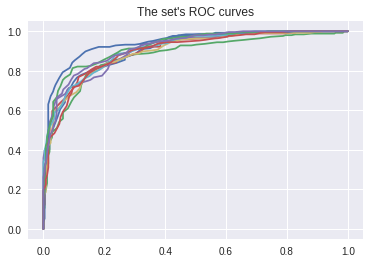

In [17]:
plt.figure()

for i in range(10):
  plt.plot(FPR[i], TPR[i])
plt.title("The set's ROC curves")

# Calculating each set's AUC
from sklearn.metrics import auc
for i in range(10):
  print("AUC{}: {}".format(i,auc(FPR[i], TPR[i])))
